# Implementation of an Artificial Neural Network (ANN) from scratch

This notebook presents the implementation of a **Multi-Layer Perceptron (MLP)** manually coded in Python, using only the `numpy` library for matrix operations.

### Goals

The main objective of this project is to analyse the fundamental mechanisms of deep learning by coding the essential building blocks of a neural network:
1.  **Modularity:** Definition of a basic `Module` class to enable the chaining of layers.
2.  **Layers:** Implementation of the linear layer (`Linear`) and the activation function (`ReLU`).
3.  **Learning:** Manual implementation of the loss function (`MSE`) and, above all, the **backpropagation** mechanism (`backward` pass) for training.


### Dataset

We use the **mini-MNIST** dataset, a simplified version of the famous handwritten digit dataset, to validate our implementation on a multi-class classification task.

# Beggining of the code

## 1. Implementation of basic concepts

### 1.1. Useful imports

In [128]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray' # To ensure that the images are in greyscale
import scipy.ndimage as ndimage
import scipy.optimize as optimize

import os

This project adopts an Object-Oriented Programming approach to build the neural network in a modular way. Each component (layer, activation function, loss function) is implemented to be independant. Here we define the classes `Module`, `Linear`, `ReLU`, `MSE` and the architecture `SimpleMLP` (only one layer and fixed dimension for the start).

### 1.1. Basic Classes and Methods

`Module` is used to define the interface between each calcul.

`MSE` is used to compute the error of the prediction, by using a ean-squarred error.

`Linear` is used to compute the linear transformation in the neural Network.

`ReLU` is used to compute the max(0, a) where a is the value compute with `Linear`.

`SimpleMLP` is used to be a simple neural network.


In [129]:
class Module(object):
    def __init__(self):
        self.gradInput = None
        self.output = None

    def forward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError

    def backward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError


class MSE(Module):
    """
    This implementation of the mean squared loss assumes that the data comes as a 2-dimensional array
    of size (batch_size, num_classes) and the labels as a vector of size (batch_size)
    """
    def __init__(self, num_classes=10):
        super(MSE, self).__init__()
        self.num_classes = num_classes

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1

        return target

    def forward(self, x, labels):
        target = self.make_target(x, labels)
        self.output = np.sum((target-x)**2, axis=1)
        return np.mean(self.output)

    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = -2*(target - x) / x.shape[0]
        return self.gradInput


class Linear(Module):
    """
    The input is supposed to have two dimensions (batch_size, in_features)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        std = math.sqrt(2/in_features)
        self.weight = std*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)

    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput

    def gradientStep(self, lr):
        self.weight = self.weight - lr*self.gradWeight
        self.bias = self.bias - lr*self.gradBias


class ReLU(Module):
    def __init__(self, bias=True):
        super(ReLU, self).__init__()

    def forward(self, x):
        self.output = x.clip(0)
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = (x>0) * gradOutput
        return self.gradInput


class SimpleMLP(Module):
    """
    This class is a simple example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, num_classes)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)

## 2. Data Preparation

### 2.1. Loading MNIST Data

We use the **mini-MNIST** dataset for training and evaluation.

In [130]:
data = np.load("mini_mnist.npz")

train_data = data["train_data"]
train_labels = data["train_labels"]
test_data = data["test_data"]
test_labels = data["test_labels"]


N_val = int(0.1 * len(train_data))
val_data = train_data[-N_val:]
val_labels = train_labels[-N_val:]

N_train = len(train_data) - N_val
train_data = train_data[:N_train]
train_labels = train_labels[:N_train]

N_test = test_data.shape[0]

print(f'n_train={N_train}, n_val={N_val}, n_test={N_test}')



n_train=9000, n_val=1000, n_test=2000


### 2.2. Data Visualisation

Visualisation of some data in order to better understand what we are working with.

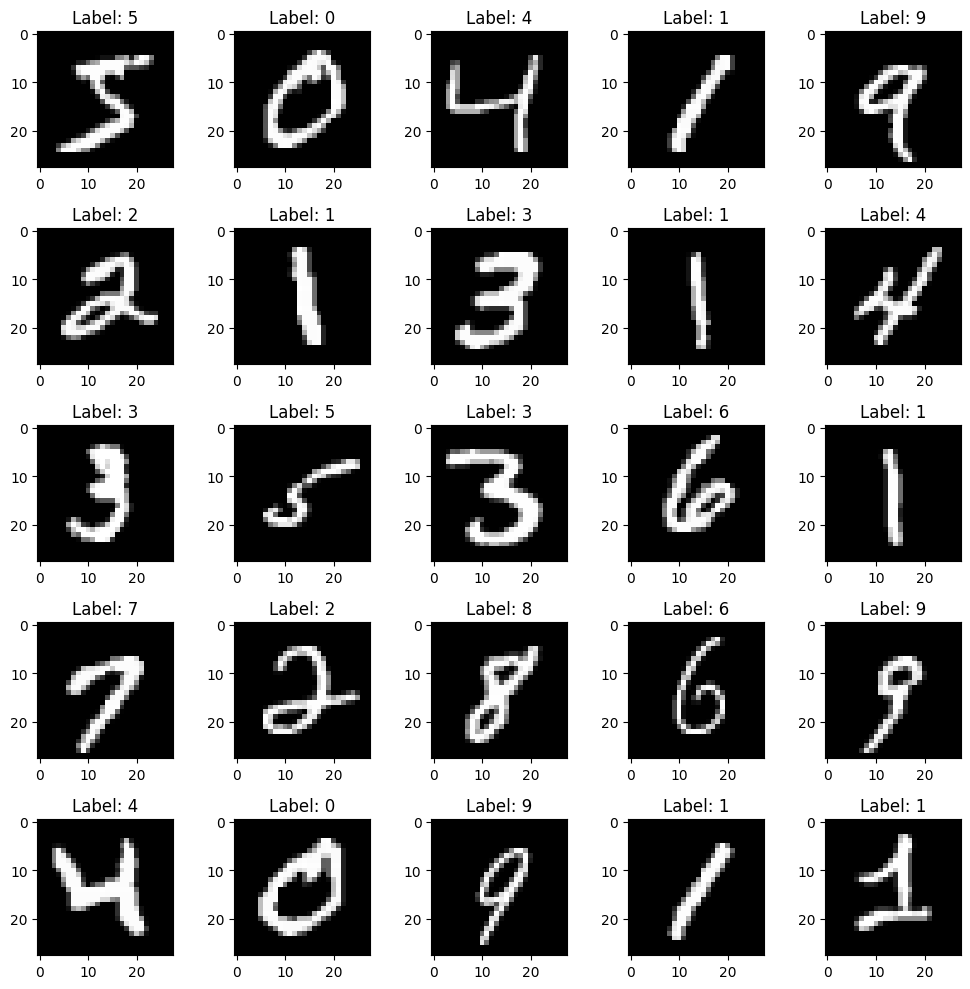

In [131]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        ax = axes[i, j]
        ax.imshow(train_data[index].reshape(28, 28))
        ax.set_title(f'Label: {train_labels[index]}')

plt.tight_layout()
plt.show()



We can already see that the numbers 1 and 7 have two different spellings. This could be a source of error.

# 3. First model

### 3.1. First train function

In [132]:
def train_iter(model, loss, batch_data, batch_labels, lr):

    #1.Make the predictions (model.forward)
    predictions = model.forward(batch_data)

    #2.Compute the loss between the predictions and the labels (loss.forward)
    loss_value = loss.forward(predictions, batch_labels)

    #3.Compute its gradient wrt the predictions and the labels (loss.backward)
    grad_loss = loss.backward(predictions, batch_labels)

    #4 .Backpropagate the gradient into the model (model.backward)
    model.backward(batch_data, grad_loss)

    #5.Perform gradient descent (model.gradientStep)
    model.gradientStep(lr)

    return loss_value

### 3.2 **The test**:

In [133]:
lr = 1e-2
batch_size = 16

#Initialisation
model = SimpleMLP(in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)


#We shuffle the data
indices = np.arange(N_train)
np.random.shuffle(indices)
shuffled_train_data = train_data[indices]
shuffled_train_labels = train_labels[indices]


#Here, we miss some of the data, but, because we shuffle them and we will do multiple epochs, It is not really important
num_batches = N_train // batch_size

#We start the training
for batch_i in range(num_batches):

    #To get the batch we need to use for the iteration i
    start_i = batch_i * batch_size
    end_i = start_i + batch_size

    batch_data = shuffled_train_data[start_i:end_i]
    batch_labels = shuffled_train_labels[start_i:end_i]

    #The train
    batch_loss = train_iter(model, loss, batch_data, batch_labels, lr)

    #Print
    if batch_i % 10 == 0:
        print(f"Iteration {batch_i}, Loss: {batch_loss}")



Iteration 0, Loss: 2.38211763026713
Iteration 10, Loss: 1.0841918357088531
Iteration 20, Loss: 1.0736008930424967
Iteration 30, Loss: 0.8922637950928083
Iteration 40, Loss: 0.8616131623241803
Iteration 50, Loss: 0.7465948297189237
Iteration 60, Loss: 0.7829072369587049
Iteration 70, Loss: 0.6572065837624819
Iteration 80, Loss: 0.6280037648892283
Iteration 90, Loss: 0.8916794726472717
Iteration 100, Loss: 0.7150645148796559
Iteration 110, Loss: 0.6185743805721151
Iteration 120, Loss: 0.6226211955676878
Iteration 130, Loss: 0.7020662928590671
Iteration 140, Loss: 0.7719497546587037
Iteration 150, Loss: 0.7881007232533876
Iteration 160, Loss: 0.6904923726559269
Iteration 170, Loss: 0.686310857159651
Iteration 180, Loss: 0.574062034706731
Iteration 190, Loss: 0.6734032714968428
Iteration 200, Loss: 0.5416076478558133
Iteration 210, Loss: 0.4561078805169875
Iteration 220, Loss: 0.6067491407295414
Iteration 230, Loss: 0.5794883136477584
Iteration 240, Loss: 0.5839569430277078
Iteration 250, 

### 3.3 Evaluate function for a model

In [134]:
def evaluate(model, loss, data, labels):

  predictions = model.forward(data)
  loss_value = loss.forward(predictions, labels)
  predicted_classes = np.argmax(predictions, axis = 1)

  accuracy_value = np.mean(predicted_classes == labels)

  return (loss_value, accuracy_value)

In [135]:
(loss_value, accuracy_value) = evaluate(model, loss, val_data, val_labels)
print(f"Loss value: {loss_value}, Accuracy_value: {accuracy_value}")

Loss value: 0.39385411286914407, Accuracy_value: 0.846


### 3.4. Inspection of Predictions

For a better understanding, let us examine the model's predictions on a few images from the validation set.

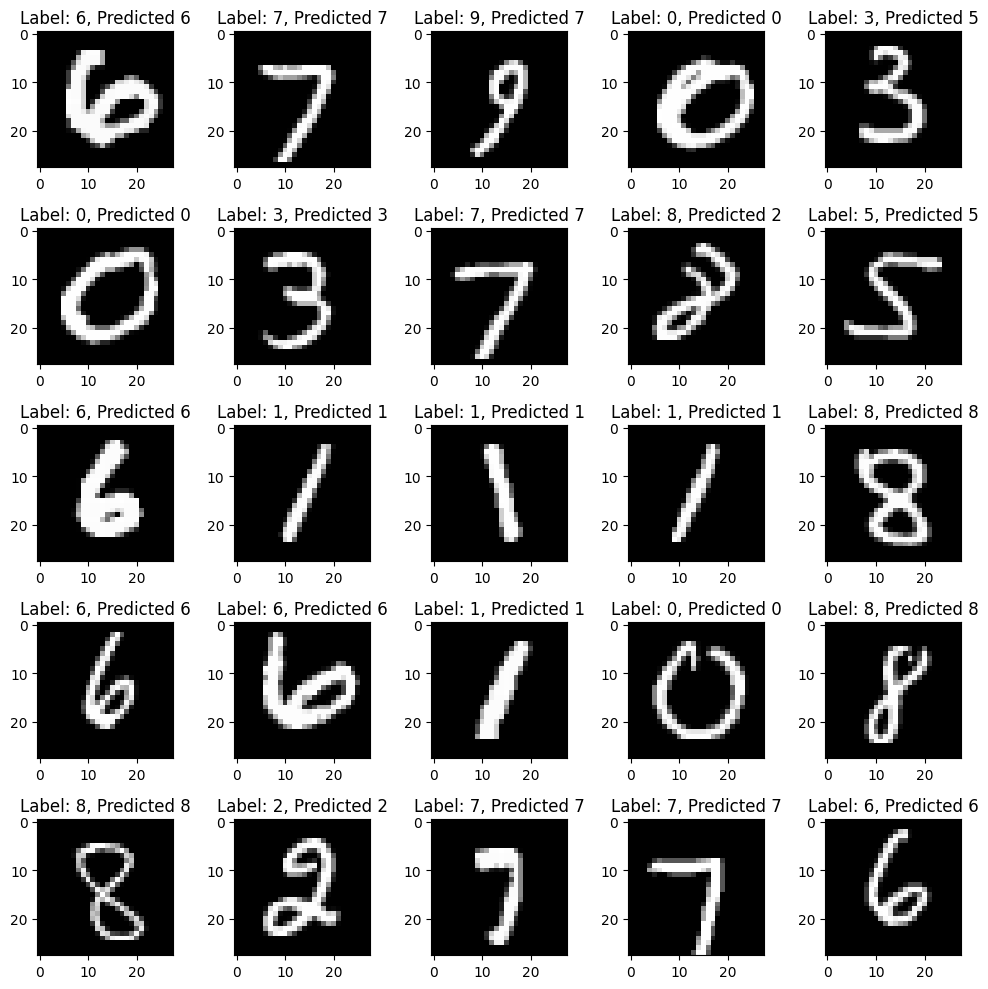

In [136]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

data_used = val_data[:25]
label_used = val_labels[:25]

predictions = model.forward(data_used)
predicted_classes = np.argmax(predictions, axis = 1)

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        ax = axes[i, j]
        ax.imshow(data_used[index].reshape(28, 28))
        ax.set_title(f'Label: {label_used[index]}, Predicted {predicted_classes[index]}')

plt.tight_layout()
plt.show()

#This helps us understand what can cause problems. For example, the number 8 is sometimes interpreted as a 2 because of the design.

Now, we want to know what makes our model fail in order to improve it. So I will display some stats about errors.

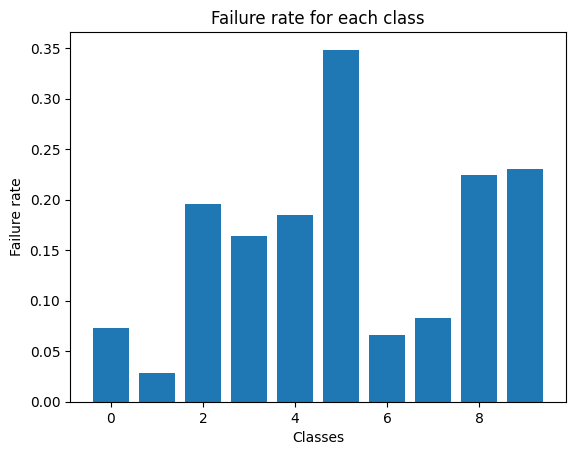

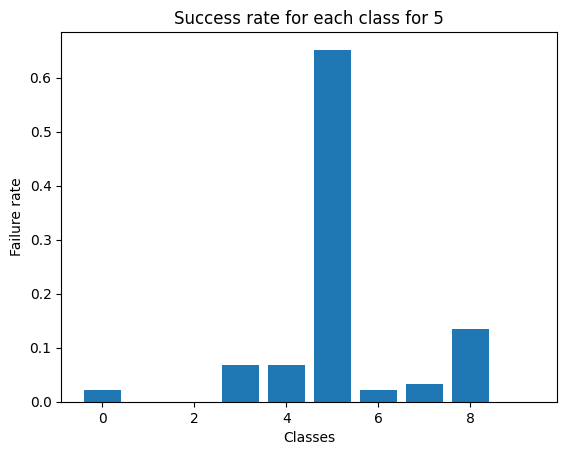

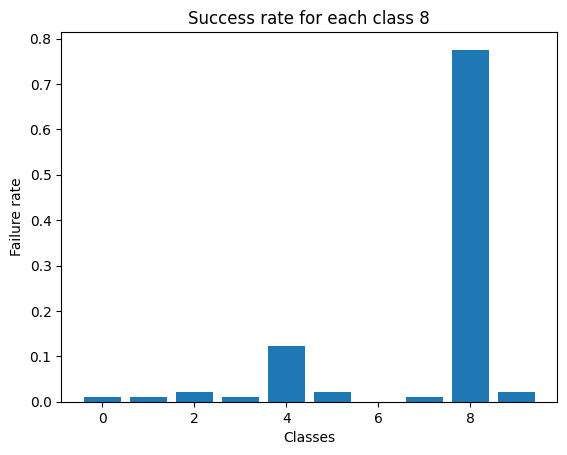

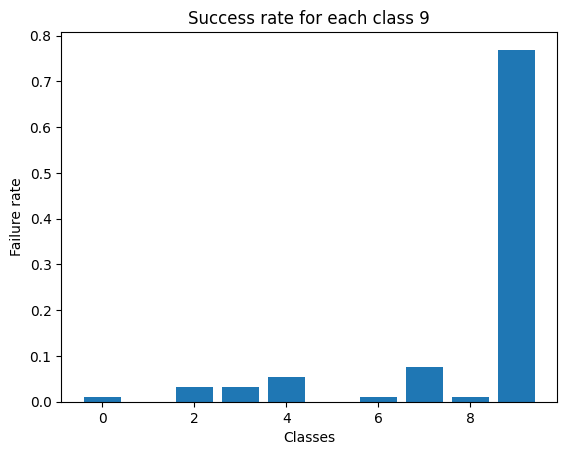

In [137]:
#Firstly, we compute the success
predicted_val_data_tot = model.forward(val_data)
unique_elements, counts = np.unique(val_labels, return_counts=True)

predictions_tot_val_data = model.forward(val_data)
predicted_tot_val_classes = np.argmax(predictions_tot_val_data, axis = 1)

success_and_failure = np.zeros((10, 10), dtype=float)

#Now, we list all the results in the right place (failure and success)
for i in range(len(val_labels)):
  success_and_failure[val_labels[i]][predicted_tot_val_classes[i]] += 1.

success_and_failure_rate = [0 for i in range(10)]
for i in range(10):
  #Here we know that all the classes have at least one element
  success_and_failure_rate[i] = success_and_failure[i]/counts[i]

failure_rate = [1 - success_and_failure_rate[i][i] for i in range(10)]


#plot the first diagram
plt.bar([i for i in range(10)], failure_rate)
plt.title('Failure rate for each class')
plt.xlabel('Classes')
plt.ylabel('Failure rate')
plt.show()

# I ploted all the success rate for the classes with the higher failure rate to understand it better

plt.bar([i for i in range(10)], [success_and_failure_rate[5][i] for i in range(10)])
plt.title('Success rate for each class for 5')
plt.xlabel('Classes')
plt.ylabel('Failure rate')
plt.show()

plt.bar([i for i in range(10)], [success_and_failure_rate[8][i] for i in range(10)])
plt.title('Success rate for each class 8')
plt.xlabel('Classes')
plt.ylabel('Failure rate')
plt.show()

plt.bar([i for i in range(10)], [ success_and_failure_rate[9][i] for i in range(10)])
plt.title('Success rate for each class 9')
plt.xlabel('Classes')
plt.ylabel('Failure rate')
plt.show()

#It shows that the 4 is an error source for 8 and 9, 8 is one also for 9 but 9 is not for 8
#It means that the model says to many time that some numbers are 8













We will plot for each class the rate of failure when the model predict it


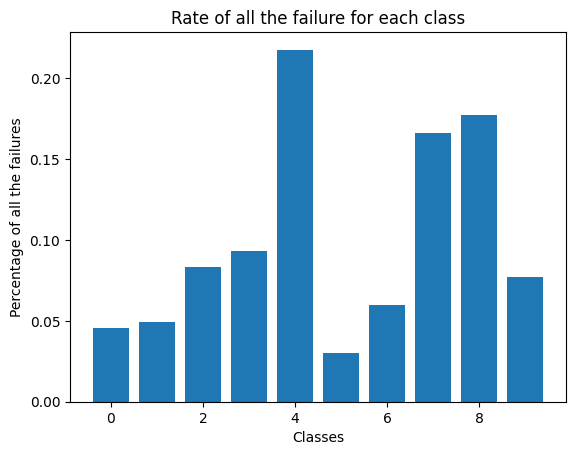

In [138]:
fail_for_each_class = [sum(success_and_failure_rate[j][i] for j in range(10) if i != j) for i in range(10)]
nb_tot_errors = sum(fail_for_each_class[i] for i in range(10))
fail_for_each_class_rate = [fail_for_each_class[i]/nb_tot_errors for i in range(10)]


plt.bar([i for i in range(10)], fail_for_each_class_rate)
plt.title('Rate of all the failure for each class')
plt.xlabel('Classes')
plt.ylabel('Percentage of all the failures')
plt.show()


We see here that 7 and 4 are some important errors.
We can explain it because, when you write something fast, it is not very clear.
So your 1 can become 7, or your 9 a 7.
Also, the 4 is depending of the person, that can explain it.
We can close or let the loop open

Also, here, we see that there is almost zeros errors for 0 and 1, it is because
there are commun and not hard to write

# 4. Training a neural network

In [139]:
def train_epoch(model, loss, data, labels, val_data, val_labels, lr, batch_size):

  # Shuffle
  indices = np.arange(len(data))
  np.random.shuffle(indices)
  shuffled_data = data[indices]
  shuffled_labels = labels[indices]

  num_batches = len(data) // batch_size

  accuracie = []

  for batch_i in range(num_batches):
    #Current batch
    start_i = batch_i * batch_size
    end_i = start_i + batch_size
    batch_data = shuffled_data[start_i:end_i]
    batch_labels = shuffled_labels[start_i:end_i]

    #Training
    train_loss = train_iter(model, loss, batch_data, batch_labels, lr)

    #Completion of accuracie
    if batch_i % 10 == 0:
        (val_loss, val_accuracy) = evaluate(model, loss, val_data, val_labels)
        accuracie.append([train_loss, val_loss, val_accuracy])

  return accuracie

In [ ]:
#Initialisation
lr = 1e-2
batch_size = 16

epochs = 2

model_test_3_a = SimpleMLP(in_dimension=784, num_classes=10)
loss_test_3_a = MSE(num_classes=10)

all_accuracies = []


#Training
for epoch in range(epochs):

    accuracie_of_the_epoch = train_epoch(model_test_3_a, loss_test_3_a, train_data, train_labels, val_data, val_labels, lr, batch_size)
    all_accuracies += accuracie_of_the_epoch

print(all_accuracies)




[[np.float64(2.1646719091026116), np.float64(1.6410995650456632), np.float64(0.088)], [np.float64(1.3128247319580901), np.float64(1.1358542558505806), np.float64(0.24)], [np.float64(1.0446109013808458), np.float64(0.9808654257606482), np.float64(0.352)], [np.float64(0.8968487952690636), np.float64(0.8875433304613255), np.float64(0.443)], [np.float64(0.8769706149251058), np.float64(0.8431555254375644), np.float64(0.479)], [np.float64(0.6903986279742601), np.float64(0.8011931906418496), np.float64(0.516)], [np.float64(0.6612935867931298), np.float64(0.7610154488857618), np.float64(0.566)], [np.float64(0.9101911621762251), np.float64(0.7332093619880502), np.float64(0.586)], [np.float64(0.6968596668685451), np.float64(0.7129989334739238), np.float64(0.6)], [np.float64(0.6907784473472762), np.float64(0.6904631240004234), np.float64(0.625)], [np.float64(0.6055018962362054), np.float64(0.6774491432601228), np.float64(0.625)], [np.float64(0.6703049140883671), np.float64(0.6581307189048357), np

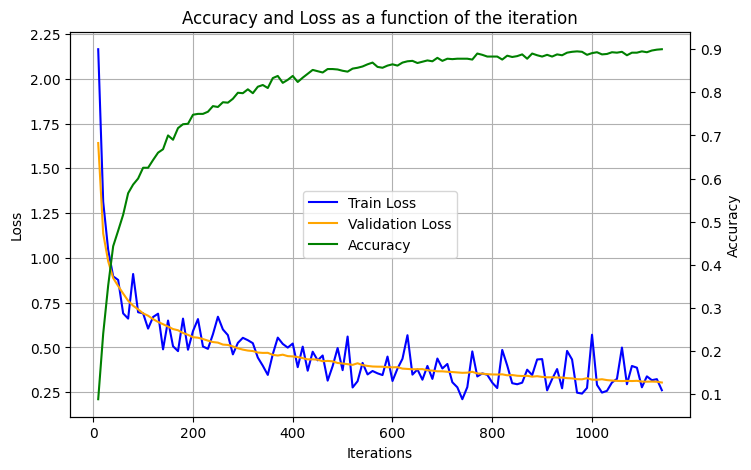

In [ ]:
iterations    = [10*(i+1) for i in range(len(all_accuracies))]
train_losses  = [ite[0] for ite in all_accuracies]
val_losses    = [ite[1] for ite in all_accuracies]
accuracy_plot = [ite[2] for ite in all_accuracies]


fig, ax1 = plt.subplots(figsize=(8, 5))

# We plot accuracy on antoher scale
#ax1 is for validation loss and train loss

ax1.plot(iterations, train_losses, color='blue', label='Train Loss')
ax1.plot(iterations, val_losses, color='orange', label='Validation Loss')

ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.grid(True)

#ax2 id for the accuracy
ax2 = ax1.twinx()
ax2.plot(iterations, accuracy_plot, color='green', label='Accuracy')
ax2.set_ylabel('Accuracy')

#Legend and plot
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center')

plt.title('Accuracy and Loss as a function of the iteration')
plt.show()

The next function,

<center><pre>train(model, loss, train_data, train_labels, val_data, val_labels, ...)</pre></center>

will train the model with different parameters, it will help us to fit it better.

In [142]:
def train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number):

  all_accuracies = []

  #Training
  for epoch in range(epochs_number):

      accuracie_of_the_epoch = train_epoch(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size)
      all_accuracies += accuracie_of_the_epoch

  #ploting

  iterations    = [10*(i+1) for i in range(len(all_accuracies))]
  train_losses  = [ite[0] for ite in all_accuracies]
  val_losses    = [ite[1] for ite in all_accuracies]
  accuracy_plot = [ite[2] for ite in all_accuracies]


  ig, ax1 = plt.subplots(figsize=(8, 5))

  #We plot accuracy on antoher scale
  #ax1 is for validation loss and train loss

  ax1.plot(iterations, train_losses, color='blue', label='Train Loss')
  ax1.plot(iterations, val_losses, color='orange', label='Validation Loss')

  ax1.set_xlabel('Iterations')
  ax1.set_ylabel('Loss')
  ax1.grid(True)

  #ax2 id for the accuracy
  ax2 = ax1.twinx()
  ax2.plot(iterations, accuracy_plot, color='green', label='Accuracy')
  ax2.set_ylabel('Accuracy')

  #Legend and plot
  lines_1, labels_1 = ax1.get_legend_handles_labels()
  lines_2, labels_2 = ax2.get_legend_handles_labels()
  ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center')

  plt.title('Accuracy and Loss as a function of the iteration')
  plt.show()

  print(f"The final accuracy is {all_accuracies[-1][2]}")
  #return accuracies[-1][2] this line of code is when I do a grid search

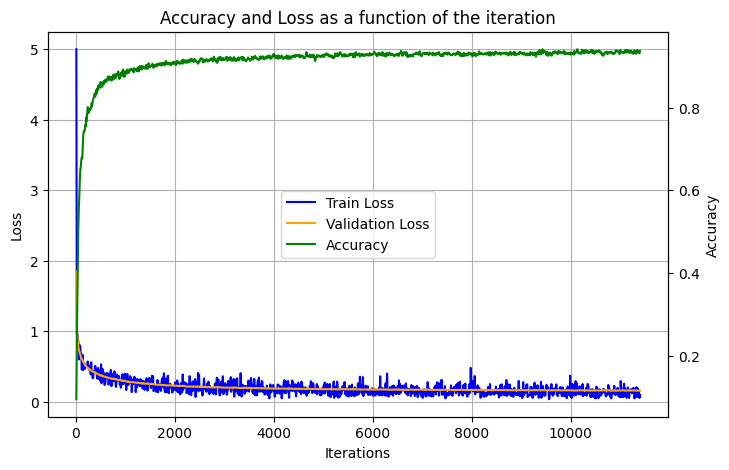

The final accuracy is 0.937


In [143]:
#In order to have the best results, I used a grid search and my best parameters gave me 0.96 percent one time
#Also, we could use a very much larger batch and number of epoch. But it was very time intensive because of the number of epoch.

lr = 0.013000
epochs = 20
batch_size = 16

model = SimpleMLP(in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs)







## Part II. Increasing the number of layers


We will increase the number of dimension.

I will change the class SimpleMLP in order to be able the change the dimension of the layer (but still one).

In [144]:
# Your code
class SimpleMLP(Module):

    def __init__(self, dimension_hidden_layer = 64, in_dimension=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, dimension_hidden_layer)
        self.relu1 = ReLU()
        self.fc2 = Linear(dimension_hidden_layer, num_classes)

    def forward(self, x):
        # Passe avant: Linear -> ReLU -> Linear
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x

    def backward(self, x, gradient):
        # Rétropropagation: Linear <- ReLU <- Linear
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient

    def gradientStep(self, lr):
        # Mise à jour des poids de toutes les couches entraînables
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)


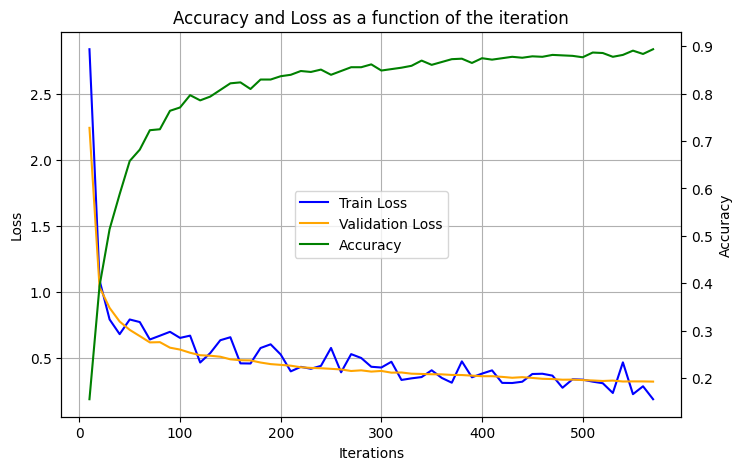

The final accuracy is 0.894


In [145]:
epochs_number = 1
model = SimpleMLP(128, in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.017000
batch_size = 16

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)

#Here we don't have a very good accuracy, it is because we do only one epoch,doing more should increase the result.

**Now, we want to have multiple layers.**

In [146]:
class DeepMLP(Module):

    def __init__(self, hidden_features, nonLinear = ReLU(), in_dimension=784, num_classes=10):
        super(DeepMLP, self).__init__()

        self.hidden_features = list(hidden_features)
        self.in_dimension = in_dimension
        self.num_classes = num_classes

        # Build linear layers, one more than the len(hidden_features)
        sizes = [in_dimension] + self.hidden_features + [num_classes]

        self.sizes = sizes
        self.linears = []
        self.non_linear = []
        for i in range(len(sizes) - 1):
            L = Linear(sizes[i], sizes[i+1])
            self.linears.append(L)

            if i < len(sizes) - 2:
                self.non_linear.append(nonLinear)

    def forward(self, x):
        for i in range(len(self.sizes) - 1):
            x = self.linears[i].forward(x)

            if i < len(self.sizes) - 2:
                x = self.non_linear[i].forward(x)

        return x

    def backward(self, x, gradient):
        current_grad = gradient


        for i in range(len(self.sizes)-2, -1, -1):
            #We need to pay attention to the exeption
            if i < len(self.sizes)-2:
                input_for_relu = self.linears[i].output
                current_grad = self.non_linear[i].backward(input_for_relu, current_grad)

            if i > 0:
              input_for_linear = self.linears[i-1].output
            else:
              input_for_linear = x

            current_grad = self.linears[i].backward(input_for_linear, current_grad)

        return current_grad

    def gradientStep(self, lr):

      for i in range(len(self.linears)-1, -1, -1):
          self.linears[i].gradientStep(lr)

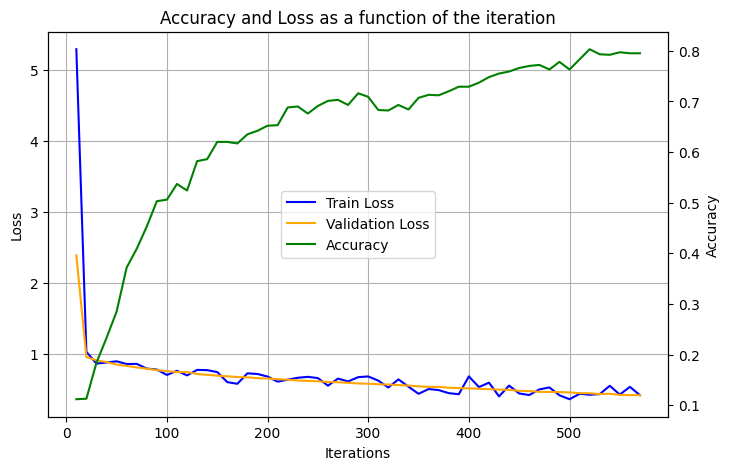

The final accuracy is 0.795


In [147]:
#We will train with 1 epoch with [64, 64, 32] hidden features and plotting.

epochs_number = 1
model = DeepMLP([64, 64, 32], in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.017000
batch_size = 16

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)


#We see that the accuracy is not as ggod as before, but it is because we did only one epoch
#It is not the optimum, especially for model with more layers.

## Part III. Differents error and loss functions


Now, I will test different error functions non linear Sigmoid, LeakyReLU and Tanh

In [148]:
class ReLU(Module):
    def __init__(self, bias=True):
        super(ReLU, self).__init__()

    def forward(self, x):
        # Applique la fonction ReLU: max(0, x)
        self.output = x.clip(0)
        return self.output

    def backward(self, x, gradOutput):
        # Le gradient est 1 si x > 0, et 0 sinon
        self.gradInput = (x>0) * gradOutput
        return self.gradInput

class Sigmoid(Module):
    def __init__(self, num_classes=10):
        super(Sigmoid, self).__init__()
        self.num_classes = num_classes

    def forward(self, x):
        self.output = 1/(1+np.exp(-x))
        return self.output

    def backward(self, x, gradOutput):
        sigmoid_x = 1/(1+np.exp(-x))
        grad_sigmoid = sigmoid_x * (1 - sigmoid_x)
        self.gradInput = gradOutput * grad_sigmoid
        return self.gradInput

class LeakyReLU(Module):

    def __init__(self, num_classes=10, alpha=0.01):
        super(LeakyReLU, self).__init__()
        self.alpha = alpha
        self.num_classes = num_classes

    def forward(self, x):
        self.output = np.where(x > 0, x, self.alpha * x)
        return self.output

    def backward(self, x, gradOutput):
        self.gradInput = np.where(x > 0, gradOutput, self.alpha * gradOutput)
        return self.gradInput

class Tanh(Module):
    def __init__(self, num_classes = 10):
        super(Tanh, self).__init__()
        self.num_classes = num_classes

    def forward(self, x):
        self.output = np.tanh(x)
        return self.output

    def backward(self, x, gradOutput):
        tanh_x = np.tanh(x)
        grad_tanh = 1 - tanh_x**2
        self.gradInput = gradOutput * grad_tanh
        return self.gradInput

========== ERROR RELU ==========


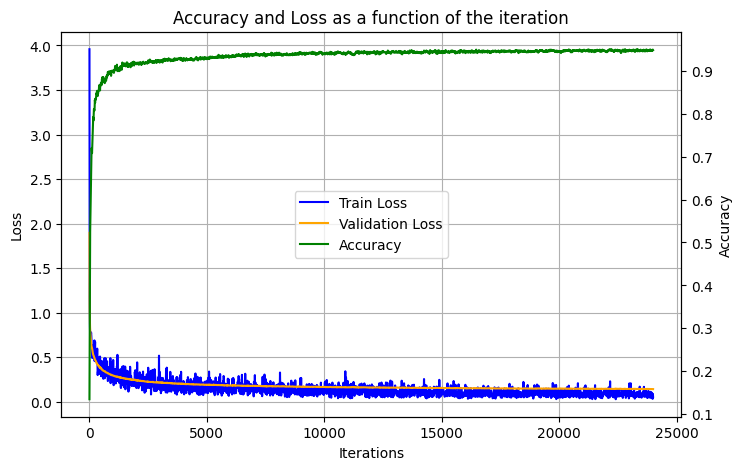

The final accuracy is 0.948
========== ERROR SIGMOID ==========


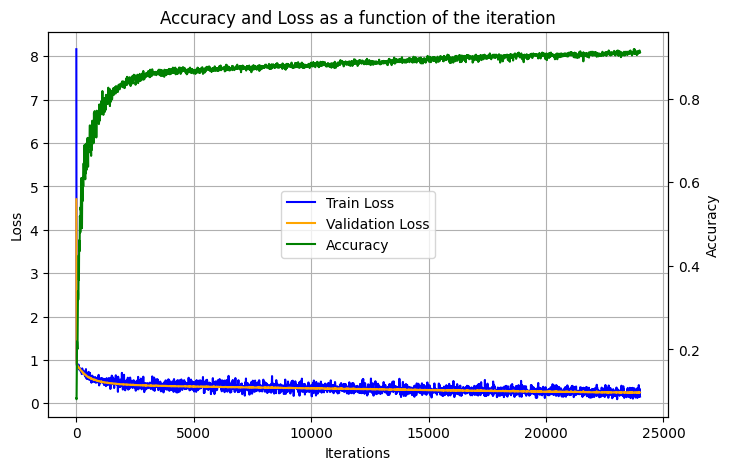

The final accuracy is 0.91
========== ERROR LEAKYRELU ==========


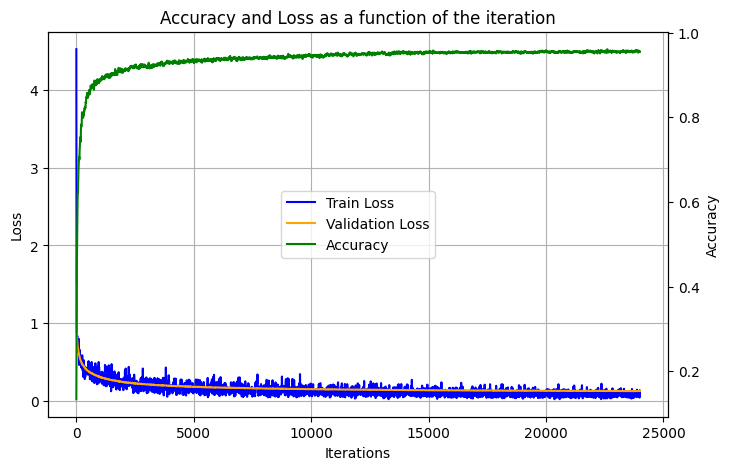

The final accuracy is 0.955
========== ERROR TANH ==========


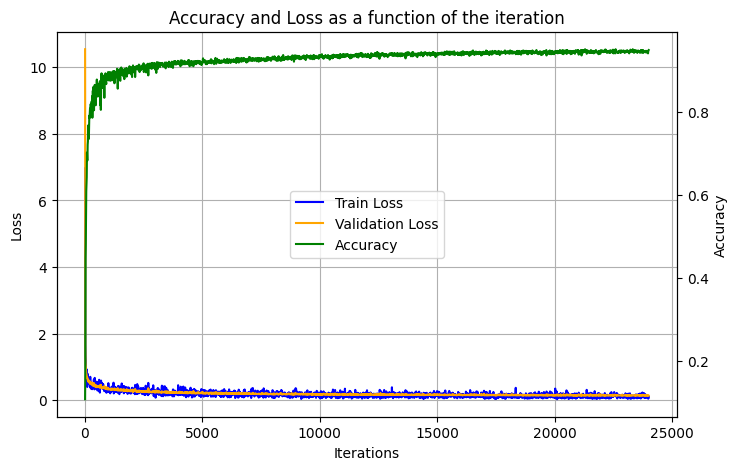

The final accuracy is 0.949


In [149]:
#Test
print("========== ERROR RELU ==========")
epochs_number = 40
model = DeepMLP([128, 64], in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)

print("========== ERROR SIGMOID ==========")
epochs_number = 40
model = DeepMLP([128, 64], Sigmoid(), in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)

print("========== ERROR LEAKYRELU ==========")
epochs_number = 40
model = DeepMLP([128, 64], LeakyReLU(),in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)

print("========== ERROR TANH ==========")
epochs_number = 40
model = DeepMLP([128, 64], Tanh(), in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)



Now, I will implent and test different loss functions L1 and Cross-Entropy

In [150]:
class L1(Module):

    def __init__(self, num_classes=10):
        super(L1, self).__init__()
        self.num_classes = num_classes

    def make_target(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1

        return target

    def forward(self, x, labels):
        target = self.make_target(x, labels)
        self.output = np.sum(np.abs(target - x), axis=1)
        return np.mean(self.output)

    def backward(self, x, labels):
        target = self.make_target(x, labels)
        self.gradInput = -np.sign(target - x) / x.shape[0]
        return self.gradInput

class CrossEntropy(Module):


    def __init__(self, num_classes=10):
        super(CrossEntropy, self).__init__()
        self.num_classes = num_classes

    def softmax(self, x):

        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, x, labels):

        probabilities = self.softmax(x)


        batch_size = x.shape[0]
        self.probabilities = probabilities


        true_class_probs = probabilities[np.arange(batch_size), labels]
        true_class_probs = np.clip(true_class_probs, 1e-12, 1.0)

        self.output = -np.log(true_class_probs)
        return np.mean(self.output)

    def backward(self, x, labels):
        batch_size = x.shape[0]

        grad = self.probabilities.copy()
        grad[np.arange(batch_size), labels] -= 1

        self.gradInput = grad / batch_size
        return self.gradInput

========== LOSS MSE ==========


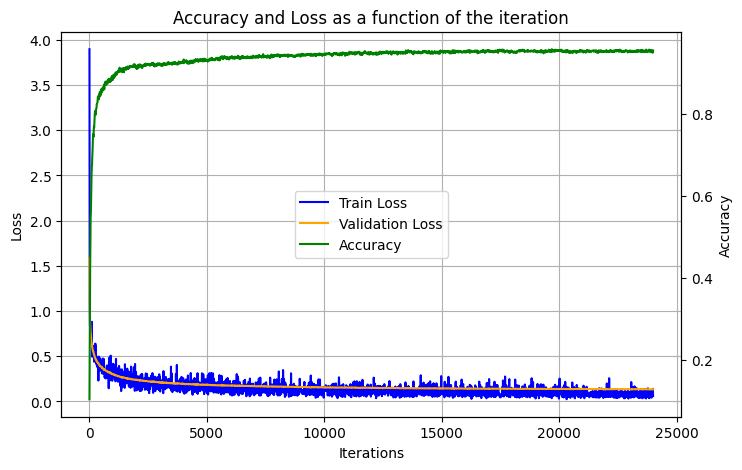

The final accuracy is 0.954
========== LOSS L1 ==========


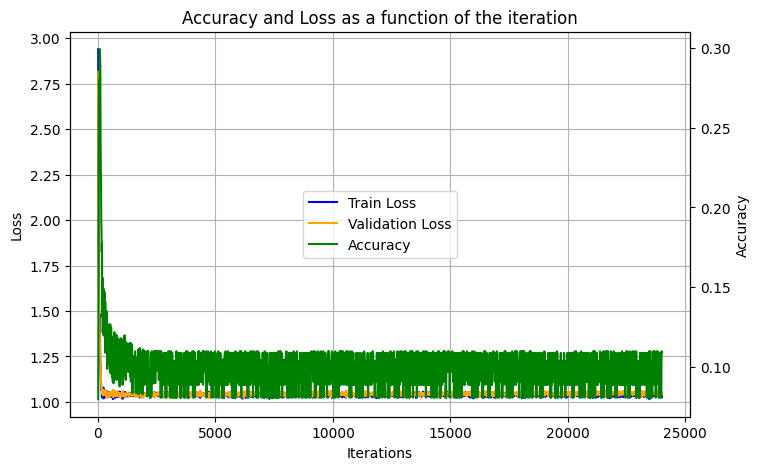

The final accuracy is 0.109
========== LOSS CROSSENTROPY ==========


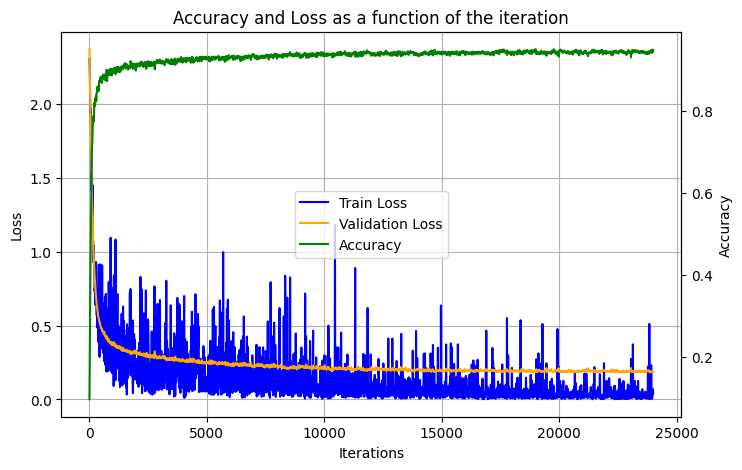

The final accuracy is 0.948


In [151]:
#Test
#I tested it on a basic ReLU fonction with the usual hyperparemeters

print("========== LOSS MSE ==========")
epochs_number = 40
model = DeepMLP([128, 64], in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)

print("========== LOSS L1 ==========")
epochs_number = 40
model = DeepMLP([128, 64], in_dimension=784, num_classes=10)
loss = L1(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)
#Here, We constat that L1 is not great. It is beacause the derivative is constant in the case. So the gradient can not gives really revelant information in this case
#The model try to minimize blindly the loss, by using the median vector (wich is great 0.10 of the time, like the accuracy we have)
print("========== LOSS CROSSENTROPY ==========")
epochs_number = 40
model = DeepMLP([128, 64], in_dimension=784, num_classes=10)
loss = CrossEntropy(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)


I will now add momentum to the training procedure to see the impact.


In [152]:
#The new class

class Linear(Module):
    """Implémentation d'une couche linéaire (fully connected layer).

    Effectue la transformation linéaire : y = x @ W.T + b.

    Attributes:
        weight (np.ndarray): Matrice des poids (out_features, in_features).
        bias (np.ndarray): Vecteur de biais (out_features,).
        gradWeight (np.ndarray): Gradient par rapport aux poids.
        gradBias (np.ndarray): Gradient par rapport au biais.
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

# Initialisation He/Kaiming pour ReLU
        std = math.sqrt(2/in_features)
        self.weight = std*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)


    def forward(self, x):
        # Calcul de la transformation linéaire: y = x @ W.T + b
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output

    def backward(self, x, gradOutput):
        # Calcul du gradient par rapport à l'entrée (gradInput)
        self.gradInput = np.dot(gradOutput, self.weight)
        # Calcul du gradient par rapport aux poids (gradWeight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        # Calcul du gradient par rapport au biais (gradBias)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput

    def gradientStep(self, lr, momentum = 0.90):
        self.weight = momentum * self.weight + (1 - momentum) * (self.weight - lr * self.gradWeight)
        self.bias   = momentum * self.bias   + (1 - momentum) * (self.bias   - lr * self.gradBias)



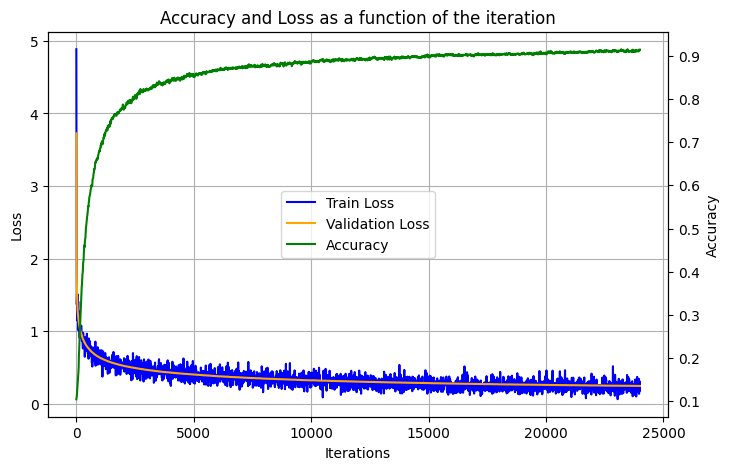

The final accuracy is 0.914


In [ ]:
epochs_number = 40
model = DeepMLP([128, 64], in_dimension=784, num_classes=10)
loss = MSE(num_classes=10)

lr = 0.01
batch_size = 15

train(model, loss, train_data, train_labels, val_data, val_labels, lr, batch_size, epochs_number)